# Variability analysis

This notebook generates 'underway' plots for the Denman/Shackleton region. Model output is used to generate plots of oceangraphic conditions for a certain day.

**Requirements:** All notebooks need to run on the `conda/analysis3` kernel. This is the most recent stable release of the `conda` environment curated by the CLEX CMS team.

First, we load any required modules. The following are pretty standard:

In [1]:
# import intake
import numpy as np

import xarray as xr
# import cf_xarray as cfxr
from xgcm import Grid
from pyproj import Transformer
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# from dask.distributed import Client

These modules are more optional:

In [2]:
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import glob                                       # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps
import cartopy.feature as cft                     # For adding features to maps

I found that sometimes dask doesn't play nice with xgcm, so let's not use dask for now. It's probably a version issue, but for now let's not use dask.

In [3]:
# client = Client()
# client

You will need to nominate a catalog from which to load your data. Unless there is a pressing need, it is best to use the default catalog:

In [4]:
# catalog = intake.cat.access_nri

Start by loading the ROMS output.

In [5]:
# simple method for loading his files - replace with intake catalog method.and
import glob
FilePath='/g/data/jk72/deg581/shacom/mdl/shackleton_v4/' 
# FilePath='../../shackleton-setup/notebooks/'#%/g/data/jk72/deg581/shacom/mdl/shackleton_v4/' # Truth file settings
prefix='roms_his_'


filelist = glob.glob(FilePath+prefix+'002*.nc')
ds = xr.open_mfdataset(filelist,{'ocean_time':1}, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Prepare the ROMS dataset for use.

In [6]:
# do special processing for ROMS formatting

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    grid = Grid(ds,
                coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
                'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
                'Z':{'center':'s_rho', 'outer':'s_w'}},
                periodic=[])

    

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + (ds.zeta+ds.zice) * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + (ds.zeta+ds.zice) * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta+ds.zice + (ds.zeta+ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta+ds.zice + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

Make some other masks that we might need.

In [7]:
mask_zice = ds.mask_rho.where((ds.zice < 0)&(ds.mask_rho==1),0)
mask_ziceNaN = mask_zice.where(mask_zice==1,np.nan)

Make a climatology from the input files, and add a new coordinate which has date values for 2025 for the dayofyear index.

In [8]:

ds_clima = ds.groupby('ocean_time.dayofyear').mean('ocean_time')

dates = np.array([np.datetime64(f"{2025}-01-01") + np.timedelta64(int(doy - 1), "D") for doy in ds_clima.dayofyear.values])



INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, re

Make new dataset with just the variables we're interested in.

In [9]:

my = (ds_clima.m*60*60*24*365) # make melt rate into m/year

ubar = grid.interp(ds_clima.ubar, 'X')
vbar = grid.interp(ds_clima.vbar, 'Y')


u_rho = grid.interp(ds_clima.u, 'X')
v_rho = grid.interp(ds_clima.v, 'Y')

temp = ds_clima.temp
salt = ds_clima.salt



# Create a new dataset
ds_shackleton = xr.Dataset(
    {
        "my": my,
        "ubar": ubar,
        "vbar": vbar,
        "u_rho":u_rho,
        "v_rho": v_rho,
        "temp": temp,
        "salt":salt,
        "z_rho0": ds.z_rho0,
        # "lon_rho": (["eta_rho", "xi_rho"], lon_rho),
        # "lat_rho": (["eta_rho", "xi_rho"], lat_rho),
        "x_rho":  ds.x_rho,
        "y_rho": ds.y_rho,
        "mask_rho":ds.mask_rho,
        "mask_zice":mask_zice,
        "mask_ziceNaN":mask_ziceNaN,
        "h": ds.h,
        "zice": ds.zice,
        "angle": ds.angle,
    },
    coords={
        "dayofyear": ds_clima.dayofyear,
        "date": dates.astype("datetime64[ns]"),
        "xi_rho": ds_clima.xi_rho,
        "eta_rho": ds_clima.eta_rho,
        "s_rho": ds_clima.s_rho,
    }
)
# by adding both dayofyear and date as coords, we can index either of them.


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

A seasonal circulation plot will give us an idea of seasonal variability - lets use xgcm to extract a chosen depth

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

Text(0.5, 0.98, 'Temperature and velocities at 400m')

<Figure size 640x480 with 0 Axes>

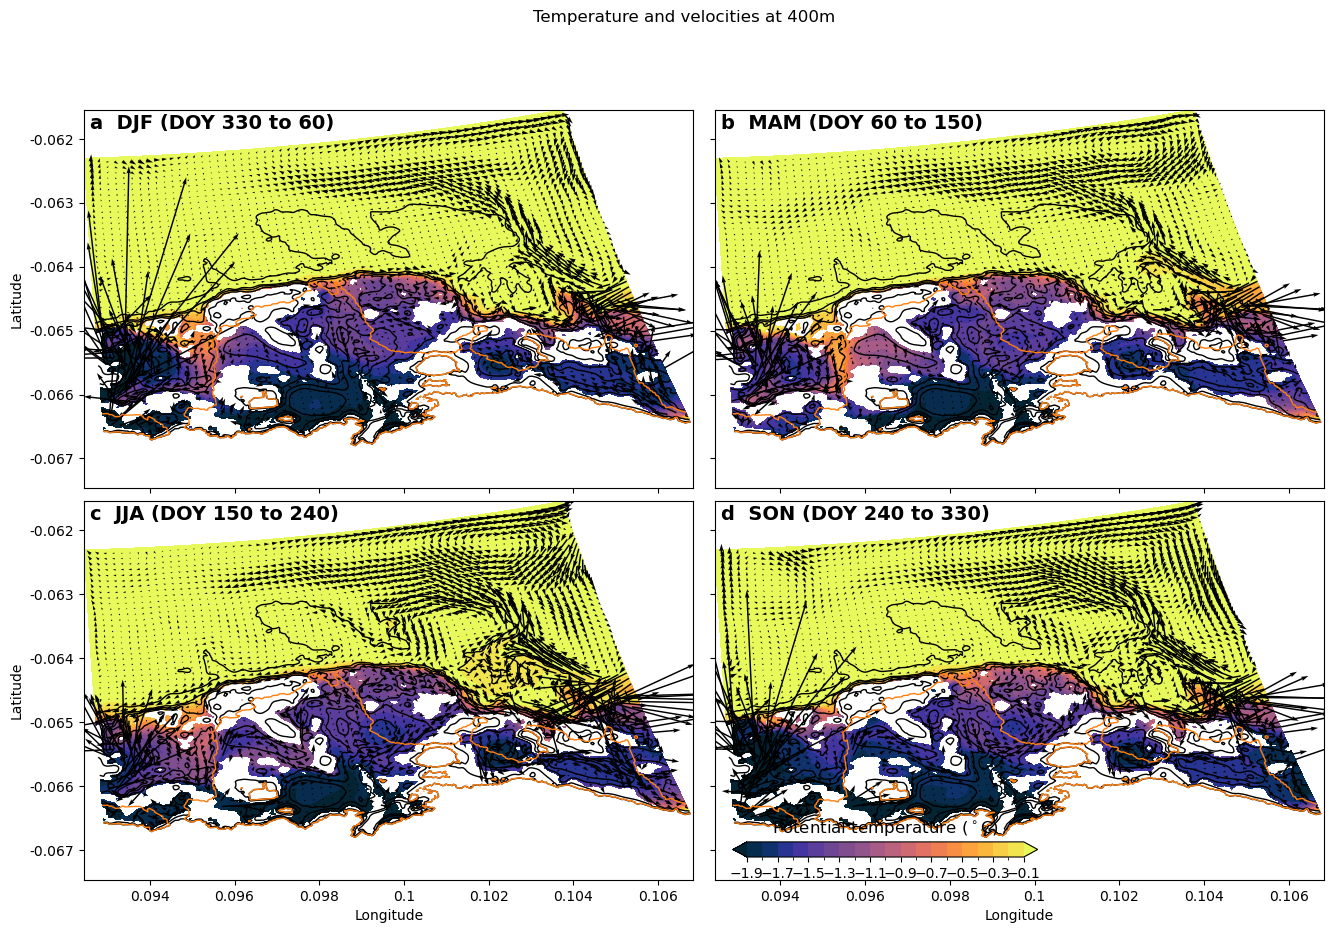

In [15]:
res=5 #arrow resolution

# define time periods
mam_period=slice(60,150)
jja_period=slice(150,240)
son_period=slice(240,330)
djf_period1=slice(330,366)
djf_period2=slice(0,60)


# make time averages for 
#velocities
us_rho_s1   = (xr.concat( [ds_shackleton.u_rho.sel(dayofyear=djf_period1),ds_shackleton.u_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
vs_rho_s1   = (xr.concat( [ds_shackleton.v_rho.sel(dayofyear=djf_period1),ds_shackleton.v_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
us_rho_s2   = ds_shackleton.u_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
vs_rho_s2   = ds_shackleton.v_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
us_rho_s3   = ds_shackleton.u_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
vs_rho_s3   = ds_shackleton.v_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
us_rho_s4   = ds_shackleton.u_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   
vs_rho_s4   = ds_shackleton.v_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   

#temperatures
temp_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
temp_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=mam_period).mean(dim='dayofyear')
temp_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=jja_period).mean(dim='dayofyear')
temp_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=son_period).mean(dim='dayofyear')
#salinities
salt_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
salt_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=mam_period).mean(dim='dayofyear')
salt_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=jja_period).mean(dim='dayofyear')
salt_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=son_period).mean(dim='dayofyear')


def extract_and_rotate(grid,ds,temp, salt, u, v, choose_depth):
    """
    Extracts temperature, salinity, and velocity components at a specified depth,
    and rotates velocity to lon/lat directions.

    Parameters:
    grid (xgcm.Grid): The grid object for vertical interpolation.
    ds (xarray.Dataset): The dataset containing ocean data.
    temp (xarray.DataArray): Temperature field.
    salt (xarray.DataArray): Salinity field.
    u (xarray.DataArray): U-velocity field.
    v (xarray.DataArray): V-velocity field.
    choose_depth (float): Depth level to extract (positive value for depth).

    Returns:
    tuple: (temp_depth, salt_depth, u_lonlat, v_lonlat) interpolated at the given depth.
    """
    temp_depth = grid.transform(temp, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()
    salt_depth = grid.transform(salt, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()

    u_depth = grid.transform(u, 'Z', np.array([-choose_depth]),
                              target_data=ds.z_rho0, method='linear').squeeze()
    v_depth = grid.transform(v,'Z', np.array([-choose_depth]),
                              target_data=ds.z_rho0, method='linear').squeeze()

    
    # Rotate velocity components
    U = u_depth + 1j * v_depth  # Convert to complex form
    rotation_factor = np.exp(1j * ds.angle)  # Compute rotation factor
    rotated_velocity = U * rotation_factor
    
    # Extract real and imaginary parts as rotated velocity components
    u_lonlat = np.real(rotated_velocity)
    v_lonlat = np.imag(rotated_velocity)
    
    return temp_depth, salt_depth, u_lonlat, v_lonlat

depth_choice = 400
temp_depth_s1, salt_depth_s1, u_lonlat_s1, v_lonlat_s1 = extract_and_rotate(grid,ds_shackleton,temp_s1, salt_s1, us_rho_s1, vs_rho_s1, depth_choice)
temp_depth_s2, salt_depth_s2, u_lonlat_s2, v_lonlat_s2 = extract_and_rotate(grid,ds_shackleton,temp_s2, salt_s2, us_rho_s2, vs_rho_s2, depth_choice)
temp_depth_s3, salt_depth_s3, u_lonlat_s3, v_lonlat_s3 = extract_and_rotate(grid,ds_shackleton,temp_s3, salt_s3, us_rho_s3, vs_rho_s3, depth_choice)
temp_depth_s4, salt_depth_s4, u_lonlat_s4, v_lonlat_s4 = extract_and_rotate(grid,ds_shackleton,temp_s4, salt_s4, us_rho_s4, vs_rho_s4, depth_choice)


plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,10])
ax = None

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.035)

choose_depth=15

ax=fig.add_subplot(gs[0,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s1.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)

ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], 
          u_lonlat_s1.values[0::res,0::res], v_lonlat_s1.values[0::res,0::res],scale=2.5)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  DJF (DOY 330 to 60)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[0,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s2.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal', levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s2.values[0::res,0::res], 
          v_lonlat_s2.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'b  MAM (DOY 60 to 150)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s3.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s3.values[0::res,0::res], 
          v_lonlat_s3.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'c  JJA (DOY 150 to 240)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s4.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s4.values[0::res,0::res], 
          v_lonlat_s4.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))

ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'd  SON (DOY 240 to 330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="4%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,0.06, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Potential temperature ($^\circ$C)')#,fontsize=14)
fig.suptitle('Temperature and velocities at '+str(depth_choice)+'m')

Same again, but let's zoom in on the area of interest

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

Text(0.5, 0.98, 'Temperature and velocities at 400m')

<Figure size 640x480 with 0 Axes>

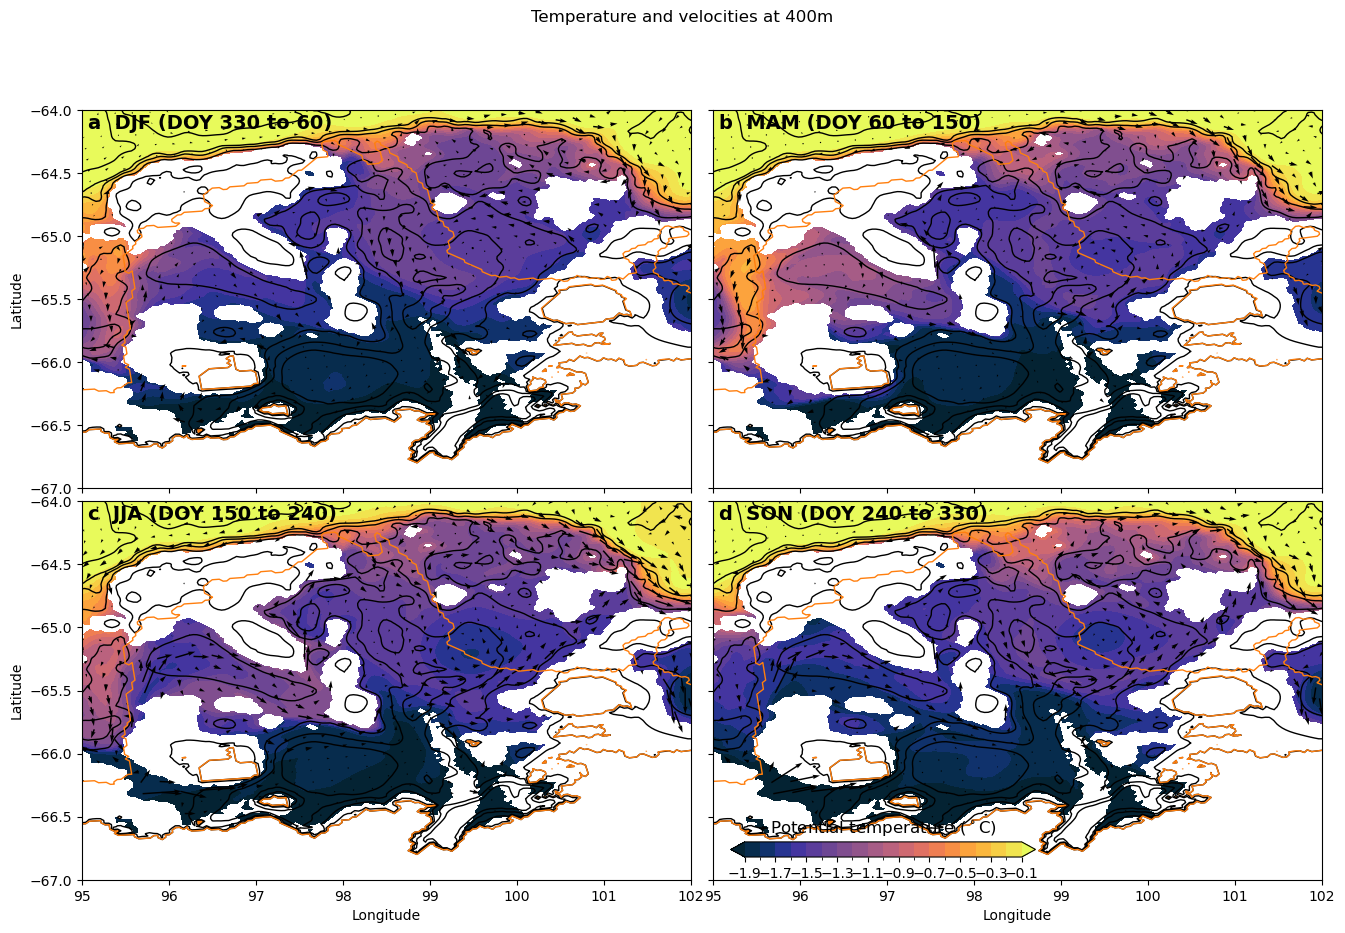

In [17]:
res=5 #arrow resolution
lon_extent=(95,102)
lat_extent=(-67,-64)

# define time periods
mam_period=slice(60,150)
jja_period=slice(150,240)
son_period=slice(240,330)
djf_period1=slice(330,366)
djf_period2=slice(0,60)


# make time averages for 
#velocities
us_rho_s1   = (xr.concat( [ds_shackleton.u_rho.sel(dayofyear=djf_period1),ds_shackleton.u_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
vs_rho_s1   = (xr.concat( [ds_shackleton.v_rho.sel(dayofyear=djf_period1),ds_shackleton.v_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
us_rho_s2   = ds_shackleton.u_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
vs_rho_s2   = ds_shackleton.v_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
us_rho_s3   = ds_shackleton.u_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
vs_rho_s3   = ds_shackleton.v_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
us_rho_s4   = ds_shackleton.u_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   
vs_rho_s4   = ds_shackleton.v_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   

#temperatures
temp_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
temp_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=mam_period).mean(dim='dayofyear')
temp_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=jja_period).mean(dim='dayofyear')
temp_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=son_period).mean(dim='dayofyear')
#salinities
salt_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
salt_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=mam_period).mean(dim='dayofyear')
salt_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=jja_period).mean(dim='dayofyear')
salt_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=son_period).mean(dim='dayofyear')


def extract_and_rotate(grid,ds,temp, salt, u, v, choose_depth):
    """
    Extracts temperature, salinity, and velocity components at a specified depth,
    and rotates velocity to lon/lat directions.

    Parameters:
    grid (xgcm.Grid): The grid object for vertical interpolation.
    ds (xarray.Dataset): The dataset containing ocean data.
    temp (xarray.DataArray): Temperature field.
    salt (xarray.DataArray): Salinity field.
    u (xarray.DataArray): U-velocity field.
    v (xarray.DataArray): V-velocity field.
    choose_depth (float): Depth level to extract (positive value for depth).

    Returns:
    tuple: (temp_depth, salt_depth, u_lonlat, v_lonlat) interpolated at the given depth.
    """
    temp_depth = grid.transform(temp, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()
    salt_depth = grid.transform(salt, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()

    u_depth = grid.transform(u, 'Z', np.array([-choose_depth]),
                              target_data=ds.z_rho0, method='linear').squeeze()
    v_depth = grid.transform(v,'Z', np.array([-choose_depth]),
                              target_data=ds.z_rho0, method='linear').squeeze()

    
    # Rotate velocity components
    U = u_depth + 1j * v_depth  # Convert to complex form
    rotation_factor = np.exp(1j * ds.angle)  # Compute rotation factor
    rotated_velocity = U * rotation_factor
    
    # Extract real and imaginary parts as rotated velocity components
    u_lonlat = np.real(rotated_velocity)
    v_lonlat = np.imag(rotated_velocity)
    
    return temp_depth, salt_depth, u_lonlat, v_lonlat

depth_choice = 400
temp_depth_s1, salt_depth_s1, u_lonlat_s1, v_lonlat_s1 = extract_and_rotate(grid,ds_shackleton,temp_s1, salt_s1, us_rho_s1, vs_rho_s1, depth_choice)
temp_depth_s2, salt_depth_s2, u_lonlat_s2, v_lonlat_s2 = extract_and_rotate(grid,ds_shackleton,temp_s2, salt_s2, us_rho_s2, vs_rho_s2, depth_choice)
temp_depth_s3, salt_depth_s3, u_lonlat_s3, v_lonlat_s3 = extract_and_rotate(grid,ds_shackleton,temp_s3, salt_s3, us_rho_s3, vs_rho_s3, depth_choice)
temp_depth_s4, salt_depth_s4, u_lonlat_s4, v_lonlat_s4 = extract_and_rotate(grid,ds_shackleton,temp_s4, salt_s4, us_rho_s4, vs_rho_s4, depth_choice)


plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,10])
ax = None

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.035)

choose_depth=15

ax=fig.add_subplot(gs[0,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s1.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)

ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], 
          u_lonlat_s1.values[0::res,0::res], v_lonlat_s1.values[0::res,0::res],scale=2.5)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  DJF (DOY 330 to 60)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[0,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s2.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal', levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s2.values[0::res,0::res], 
          v_lonlat_s2.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'b  MAM (DOY 60 to 150)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s3.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s3.values[0::res,0::res], 
          v_lonlat_s3.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'c  JJA (DOY 150 to 240)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s4.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s4.values[0::res,0::res], 
          v_lonlat_s4.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'd  SON (DOY 240 to 330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="4%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,0.06, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Potential temperature ($^\circ$C)')#,fontsize=14)
fig.suptitle('Temperature and velocities at '+str(depth_choice)+'m')

Let's use the natural vertical coordinates of ROMS to extract bottom conditions

Text(0.5, 0.98, 'Mid-depth temperature and velocities')

<Figure size 640x480 with 0 Axes>

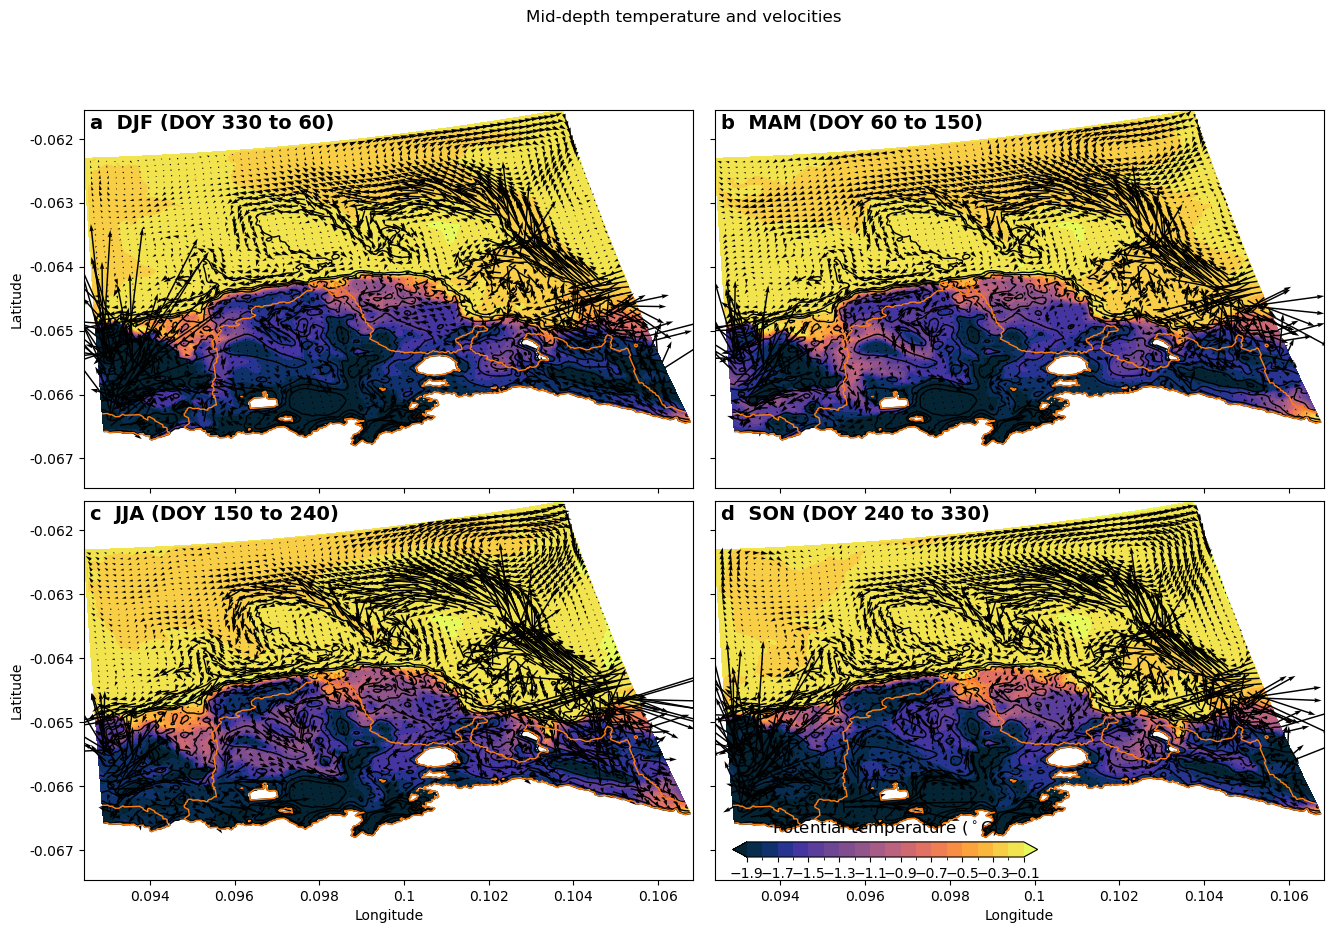

In [14]:
res=5 #arrow resolution

# define time periods
mam_period=slice(60,150)
jja_period=slice(150,240)
son_period=slice(240,330)
djf_period1=slice(330,366)
djf_period2=slice(0,60)


# make time averages for 
#velocities
us_rho_s1   = (xr.concat( [ds_shackleton.u_rho.sel(dayofyear=djf_period1),ds_shackleton.u_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
vs_rho_s1   = (xr.concat( [ds_shackleton.v_rho.sel(dayofyear=djf_period1),ds_shackleton.v_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
us_rho_s2   = ds_shackleton.u_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
vs_rho_s2   = ds_shackleton.v_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
us_rho_s3   = ds_shackleton.u_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
vs_rho_s3   = ds_shackleton.v_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
us_rho_s4   = ds_shackleton.u_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   
vs_rho_s4   = ds_shackleton.v_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   

#temperatures
temp_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
temp_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=mam_period).mean(dim='dayofyear')
temp_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=jja_period).mean(dim='dayofyear')
temp_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=son_period).mean(dim='dayofyear')
#salinities
salt_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
salt_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=mam_period).mean(dim='dayofyear')
salt_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=jja_period).mean(dim='dayofyear')
salt_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=son_period).mean(dim='dayofyear')


def extract_and_rotate(grid,ds,temp, salt, u, v, choose_layer):
    """
    Extracts temperature, salinity, and velocity components at a specified depth,
    and rotates velocity to lon/lat directions.

    Parameters:
    grid (xgcm.Grid): The grid object for vertical interpolation.
    ds (xarray.Dataset): The dataset containing ocean data.
    temp (xarray.DataArray): Temperature field.
    salt (xarray.DataArray): Salinity field.
    u (xarray.DataArray): U-velocity field.
    v (xarray.DataArray): V-velocity field.
    choose_layer (integer): ROMS layer to extract.

    Returns:
    tuple: (temp_depth, salt_depth, u_lonlat, v_lonlat) interpolated at the given depth.
    """
    temp_depth = temp.isel(s_rho=choose_layer)
    salt_depth = salt.isel(s_rho=choose_layer)

    u_depth = u.isel(s_rho=choose_layer)
    v_depth = v.isel(s_rho=choose_layer)

    
    # Rotate velocity components
    U = u_depth + 1j * v_depth  # Convert to complex form
    rotation_factor = np.exp(1j * ds.angle)  # Compute rotation factor
    rotated_velocity = U * rotation_factor
    
    # Extract real and imaginary parts as rotated velocity components
    u_lonlat = np.real(rotated_velocity)
    v_lonlat = np.imag(rotated_velocity)
    
    return temp_depth, salt_depth, u_lonlat, v_lonlat

temp_depth_s1, salt_depth_s1, u_lonlat_s1, v_lonlat_s1 = extract_and_rotate(grid,ds_shackleton,temp_s1, salt_s1, us_rho_s1, vs_rho_s1, 0)
temp_depth_s2, salt_depth_s2, u_lonlat_s2, v_lonlat_s2 = extract_and_rotate(grid,ds_shackleton,temp_s2, salt_s2, us_rho_s2, vs_rho_s2, 0)
temp_depth_s3, salt_depth_s3, u_lonlat_s3, v_lonlat_s3 = extract_and_rotate(grid,ds_shackleton,temp_s3, salt_s3, us_rho_s3, vs_rho_s3, 0)
temp_depth_s4, salt_depth_s4, u_lonlat_s4, v_lonlat_s4 = extract_and_rotate(grid,ds_shackleton,temp_s4, salt_s4, us_rho_s4, vs_rho_s4, 0)


plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,10])
ax = None

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.035)

choose_depth=15

ax=fig.add_subplot(gs[0,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s1.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)

ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], 
          u_lonlat_s1.values[0::res,0::res], v_lonlat_s1.values[0::res,0::res],scale=2.5)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  DJF (DOY 330 to 60)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[0,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s2.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal', levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s2.values[0::res,0::res], 
          v_lonlat_s2.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'b  MAM (DOY 60 to 150)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s3.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s3.values[0::res,0::res], 
          v_lonlat_s3.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'c  JJA (DOY 150 to 240)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s4.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s4.values[0::res,0::res], 
          v_lonlat_s4.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))

ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'd  SON (DOY 240 to 330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="4%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,0.06, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Potential temperature ($^\circ$C)')#,fontsize=14)
fig.suptitle('Bottom temperature and velocities')

Repeat that but zoom in to the area of interest

Text(0.5, 0.98, 'Bottom temperature and velocities')

<Figure size 640x480 with 0 Axes>

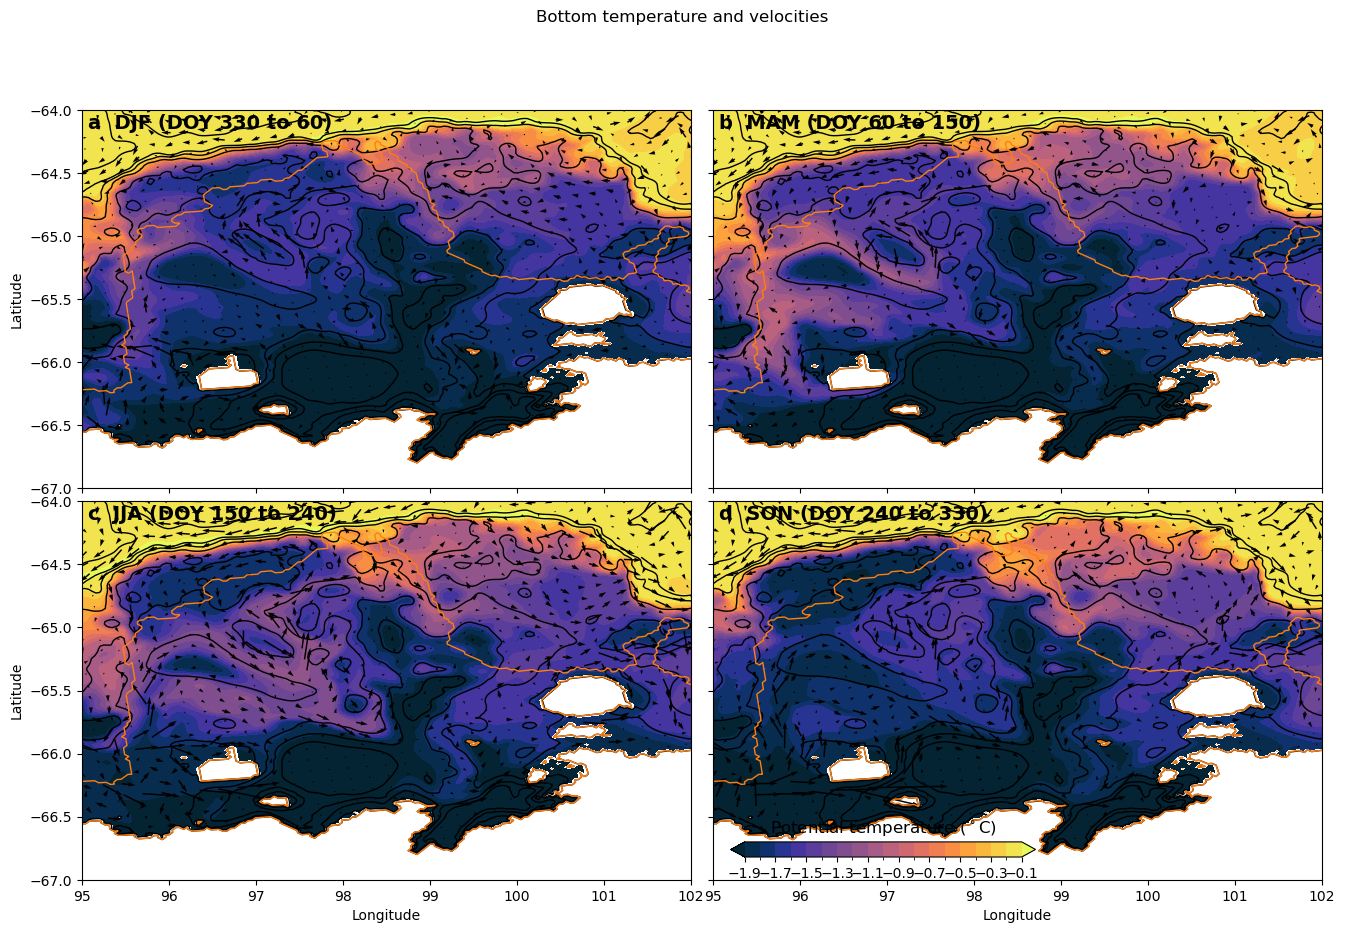

In [16]:
res=5 #arrow resolution
lon_extent=(95,102)
lat_extent=(-67,-64)

# define time periods
mam_period=slice(60,150)
jja_period=slice(150,240)
son_period=slice(240,330)
djf_period1=slice(330,366)
djf_period2=slice(0,60)


# make time averages for 
#velocities
us_rho_s1   = (xr.concat( [ds_shackleton.u_rho.sel(dayofyear=djf_period1),ds_shackleton.u_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
vs_rho_s1   = (xr.concat( [ds_shackleton.v_rho.sel(dayofyear=djf_period1),ds_shackleton.v_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
us_rho_s2   = ds_shackleton.u_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
vs_rho_s2   = ds_shackleton.v_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
us_rho_s3   = ds_shackleton.u_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
vs_rho_s3   = ds_shackleton.v_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
us_rho_s4   = ds_shackleton.u_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   
vs_rho_s4   = ds_shackleton.v_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   

#temperatures
temp_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
temp_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=mam_period).mean(dim='dayofyear')
temp_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=jja_period).mean(dim='dayofyear')
temp_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=son_period).mean(dim='dayofyear')
#salinities
salt_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
salt_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=mam_period).mean(dim='dayofyear')
salt_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=jja_period).mean(dim='dayofyear')
salt_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=son_period).mean(dim='dayofyear')


def extract_and_rotate(grid,ds,temp, salt, u, v, choose_layer):
    """
    Extracts temperature, salinity, and velocity components at a specified depth,
    and rotates velocity to lon/lat directions.

    Parameters:
    grid (xgcm.Grid): The grid object for vertical interpolation.
    ds (xarray.Dataset): The dataset containing ocean data.
    temp (xarray.DataArray): Temperature field.
    salt (xarray.DataArray): Salinity field.
    u (xarray.DataArray): U-velocity field.
    v (xarray.DataArray): V-velocity field.
    choose_layer (integer): ROMS layer to extract.

    Returns:
    tuple: (temp_depth, salt_depth, u_lonlat, v_lonlat) interpolated at the given depth.
    """
    temp_depth = temp.isel(s_rho=choose_layer)
    salt_depth = salt.isel(s_rho=choose_layer)

    u_depth = u.isel(s_rho=choose_layer)
    v_depth = v.isel(s_rho=choose_layer)

    
    # Rotate velocity components
    U = u_depth + 1j * v_depth  # Convert to complex form
    rotation_factor = np.exp(1j * ds.angle)  # Compute rotation factor
    rotated_velocity = U * rotation_factor
    
    # Extract real and imaginary parts as rotated velocity components
    u_lonlat = np.real(rotated_velocity)
    v_lonlat = np.imag(rotated_velocity)
    
    return temp_depth, salt_depth, u_lonlat, v_lonlat

temp_depth_s1, salt_depth_s1, u_lonlat_s1, v_lonlat_s1 = extract_and_rotate(grid,ds_shackleton,temp_s1, salt_s1, us_rho_s1, vs_rho_s1, 0)
temp_depth_s2, salt_depth_s2, u_lonlat_s2, v_lonlat_s2 = extract_and_rotate(grid,ds_shackleton,temp_s2, salt_s2, us_rho_s2, vs_rho_s2, 0)
temp_depth_s3, salt_depth_s3, u_lonlat_s3, v_lonlat_s3 = extract_and_rotate(grid,ds_shackleton,temp_s3, salt_s3, us_rho_s3, vs_rho_s3, 0)
temp_depth_s4, salt_depth_s4, u_lonlat_s4, v_lonlat_s4 = extract_and_rotate(grid,ds_shackleton,temp_s4, salt_s4, us_rho_s4, vs_rho_s4, 0)


plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,10])
ax = None

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.035)

choose_depth=15

ax=fig.add_subplot(gs[0,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s1.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)

ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], 
          u_lonlat_s1.values[0::res,0::res], v_lonlat_s1.values[0::res,0::res],scale=2.5)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  DJF (DOY 330 to 60)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[0,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s2.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal', levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s2.values[0::res,0::res], 
          v_lonlat_s2.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'b  MAM (DOY 60 to 150)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s3.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s3.values[0::res,0::res], 
          v_lonlat_s3.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'c  JJA (DOY 150 to 240)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s4.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-1.9,0,.1),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s4.values[0::res,0::res], 
          v_lonlat_s4.values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'd  SON (DOY 240 to 330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="4%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,0.06, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Potential temperature ($^\circ$C)')#,fontsize=14)
fig.suptitle('Bottom temperature and velocities')

Let's calculate the standard deviation in temperature at different depths

Text(0.5, 0.98, 'Temperature standard deviation at bottom')

<Figure size 640x480 with 0 Axes>

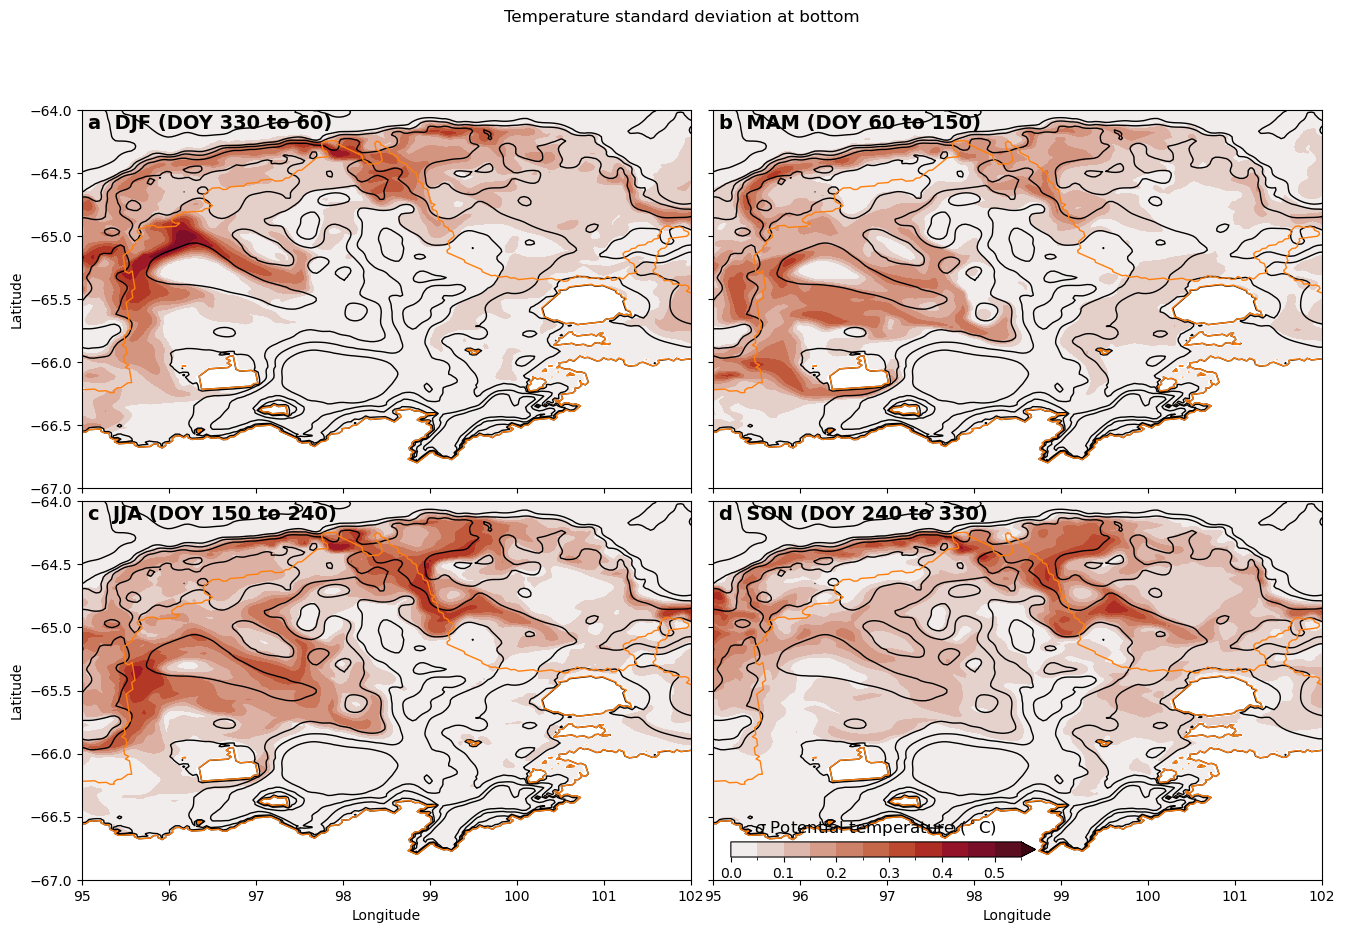

In [20]:
res=5 #arrow resolution
lon_extent=(95,102)
lat_extent=(-67,-64)

# define time periods
mam_period=slice(60,150)
jja_period=slice(150,240)
son_period=slice(240,330)
djf_period1=slice(330,366)
djf_period2=slice(0,60)

choose_layer=0

#temperatures
temp_depth_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period2)],dim='dayofyear') ).isel(s_rho=choose_layer).std(dim='dayofyear')
temp_depth_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=mam_period).isel(s_rho=choose_layer).std(dim='dayofyear')
temp_depth_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=jja_period).isel(s_rho=choose_layer).std(dim='dayofyear')
temp_depth_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=son_period).isel(s_rho=choose_layer).std(dim='dayofyear')

#salinities
salt_depth_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period2)],dim='dayofyear') ).isel(s_rho=choose_layer).std(dim='dayofyear')
salt_depth_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=mam_period).isel(s_rho=choose_layer).std(dim='dayofyear')
salt_depth_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=jja_period).isel(s_rho=choose_layer).std(dim='dayofyear')
salt_depth_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=son_period).isel(s_rho=choose_layer).std(dim='dayofyear')



plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,10])
ax = None

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.035)

choose_depth=15

ax=fig.add_subplot(gs[0,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s1.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp',levels=np.arange(0,0.6,.05),add_colorbar=False)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  DJF (DOY 330 to 60)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[0,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s2.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp', levels=np.arange(0,0.6,.05),add_colorbar=False)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'b  MAM (DOY 60 to 150)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s3.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp',levels=np.arange(0,0.6,.05),add_colorbar=False)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'c  JJA (DOY 150 to 240)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s4.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp',levels=np.arange(0,0.6,.05),add_colorbar=False)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'd  SON (DOY 240 to 330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="4%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,0.06, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\sigma$ Potential temperature ($^\circ$C)')#,fontsize=14)
fig.suptitle('Temperature standard deviation at bottom')

Now at a chosen depth

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

Text(0.5, 0.98, 'Temperature standard deviation at depth400m')

<Figure size 640x480 with 0 Axes>

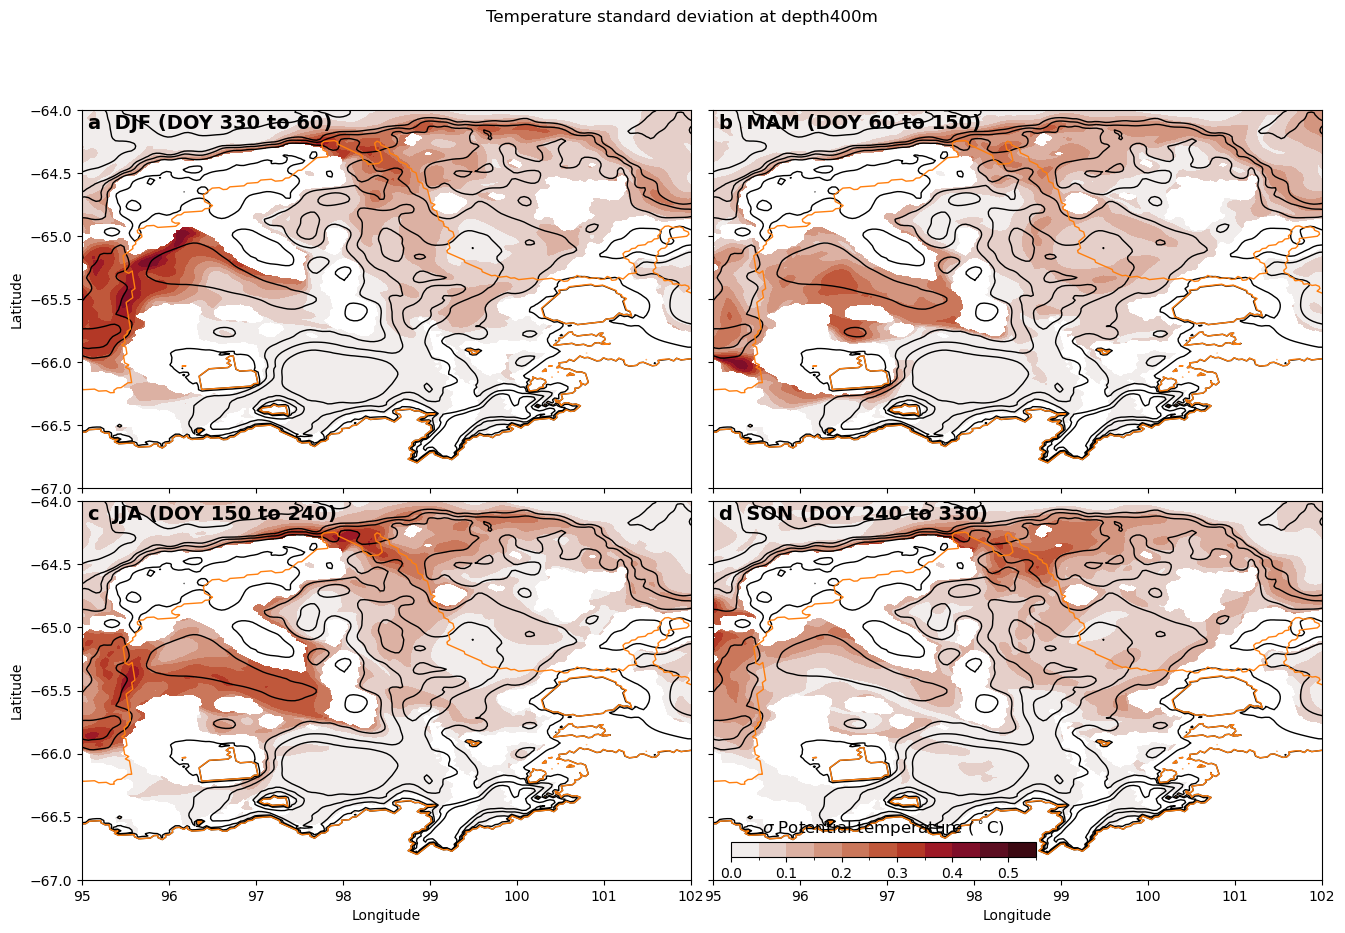

In [27]:
res=5 #arrow resolution
lon_extent=(95,102)
lat_extent=(-67,-64)

# define time periods
mam_period=slice(60,150)
jja_period=slice(150,240)
son_period=slice(240,330)
djf_period1=slice(330,366)
djf_period2=slice(0,60)

choose_layer=0

#temperatures
temp_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period2)],dim='dayofyear') )
temp_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=mam_period)
temp_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=jja_period)
temp_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=son_period)

#salinities
salt_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period2)],dim='dayofyear') )
salt_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=mam_period)
salt_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=jja_period)
salt_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=son_period)



def extract_depth(grid,ds,temp, salt, choose_depth):
    """
    Extracts temperature, salinity, at a specified depth.

    Parameters:
    grid (xgcm.Grid): The grid object for vertical interpolation.
    ds (xarray.Dataset): The dataset containing ocean data.
    temp (xarray.DataArray): Temperature field.
    salt (xarray.DataArray): Salinity field.

    choose_depth (float): Depth level to extract (positive value for depth).

    Returns:
    tuple: (temp_depth, salt_depth, u_lonlat, v_lonlat) interpolated at the given depth.
    """
    temp_depth = grid.transform(temp, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()
    salt_depth = grid.transform(salt, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()
    return temp_depth, salt_depth


depth_choice = 400
temp_depth_s1, salt_depth_s1 = extract_depth(grid,ds_shackleton,temp_s1, salt_s1, depth_choice)
temp_depth_s2, salt_depth_s2 = extract_depth(grid,ds_shackleton,temp_s2, salt_s2, depth_choice)
temp_depth_s3, salt_depth_s3 = extract_depth(grid,ds_shackleton,temp_s3, salt_s3, depth_choice)
temp_depth_s4, salt_depth_s4 = extract_depth(grid,ds_shackleton,temp_s4, salt_s4, depth_choice)

temp_depth_s1 = temp_depth_s1.std(dim='dayofyear')
temp_depth_s2 = temp_depth_s2.std(dim='dayofyear')
temp_depth_s3 = temp_depth_s3.std(dim='dayofyear')
temp_depth_s4 = temp_depth_s4.std(dim='dayofyear')

plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,10])
ax = None

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.035)

choose_depth=15

ax=fig.add_subplot(gs[0,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s1.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp',levels=np.arange(0,0.6,.05),add_colorbar=False)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  DJF (DOY 330 to 60)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[0,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s2.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp', levels=np.arange(0,0.6,.05),add_colorbar=False)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'b  MAM (DOY 60 to 150)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s3.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp',levels=np.arange(0,0.6,.05),add_colorbar=False)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'c  JJA (DOY 150 to 240)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s4.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.amp',levels=np.arange(0,0.6,.05),add_colorbar=False)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

ax.set_xlim(lon_extent)
ax.set_ylim(lat_extent)
ax.set_xlabel('Longitude')
# ax.grid()
# ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'd  SON (DOY 240 to 330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="4%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,0.06, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\sigma$ Potential temperature ($^\circ$C)')#,fontsize=14)
fig.suptitle('Temperature standard deviation at depth'+str(depth_choice)+'m')